# Introduction

## Présentation du dataset

Les données proviennent du site [Open Food Facts](https://world.openfoodfacts.org/) de l'agence Santé Publique France.

Ces données contiennent de nombreux champs textuels et numériques se rapportant à des produits alimentaires : informations générales, catégorie d'aliment, origine, nutriments, additifs, etc.

Un description précise de ces champs est disponible à [cette adresse](https://world.openfoodfacts.org/data/data-fields.txt).

Ces données sont entrées manuellement par les utilisateurs et sont donc sujettes à des saisies erronées ou incomplètes.

Notre objectif est de les nettoyer et de les étudier afin de déterminer si elles peuvent se prêter à un système d'automatisation de la saisie (auto-complétion, suggestion ou détection d'anomalies basées sur des estimations).

## Principes RGPD

Le RGPD (Règlement Général sur la Protection des Données) est un règlement européen entré en vigueur en mai 2018, conçu pour renforcer la protection des données personnelles au sein de l'Union européenne (UE) et accroître les droits des individus. Ses principaux points sont les suivants :

- **Protection des données personnelles :** Le RGPD définit les données personnelles comme toute information permettant d'identifier une personne physique, comme un nom, une adresse, un numéro d'identification, etc.

- **Consentement éclairé :** Les organisations doivent obtenir un consentement explicite des individus pour collecter et traiter leurs données personnelles. Le consentement doit être donné librement, de manière éclairée, spécifique et révocable.

- **Droits des individus :** Les individus ont le droit d'accéder à leurs données personnelles, de demander des rectifications, de s'opposer au traitement, de demander la suppression de leurs données (droit à l'oubli) et de transférer leurs données d'une organisation à une autre (portabilité des données).

- **Responsabilité des organisations :** Les organisations sont tenues de mettre en place des mesures de sécurité appropriées pour protéger les données personnelles. Elles doivent désigner un délégué à la protection des données (DPO) dans certains cas et notifier les violations de données dans les délais prescrits.

- **Sanctions en cas de non-conformité :** Le RGPD prévoit des sanctions sévères en cas de non-conformité, notamment des amendes pouvant atteindre 20 millions d'euros ou 4 % du chiffre d'affaires mondial annuel de l'organisation, selon le montant le plus élevé.

- **Portée mondiale :** Bien qu'il s'agisse d'une réglementation européenne, le RGPD a une portée mondiale. Il s'applique à toutes les organisations qui traitent des données personnelles d'individus de l'UE, quel que soit leur emplacement géographique.

Le RGPD vise à renforcer la protection de la vie privée des individus, à responsabiliser les organisations dans la gestion des données personnelles et à donner aux individus un meilleur contrôle sur leurs informations personnelles. Il a un impact significatif sur la manière dont les entreprises et les organisations gèrent les données personnelles et constitue une étape importante dans la protection de la vie privée et de la sécurité des données.

La base de données d'Open Food Facts n'est pas concernée par le RGPD puisqu'il ne s'agit pas de données personnelles.

## Aperçu rapide

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from scipy.stats import f_oneway, chi2_contingency

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv("csv/fr.openfoodfacts.org.products.csv", sep = '\t')
data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
print("Dimensions du dataset :", data.shape)

Dimensions du dataset : (320772, 162)


<Axes: >

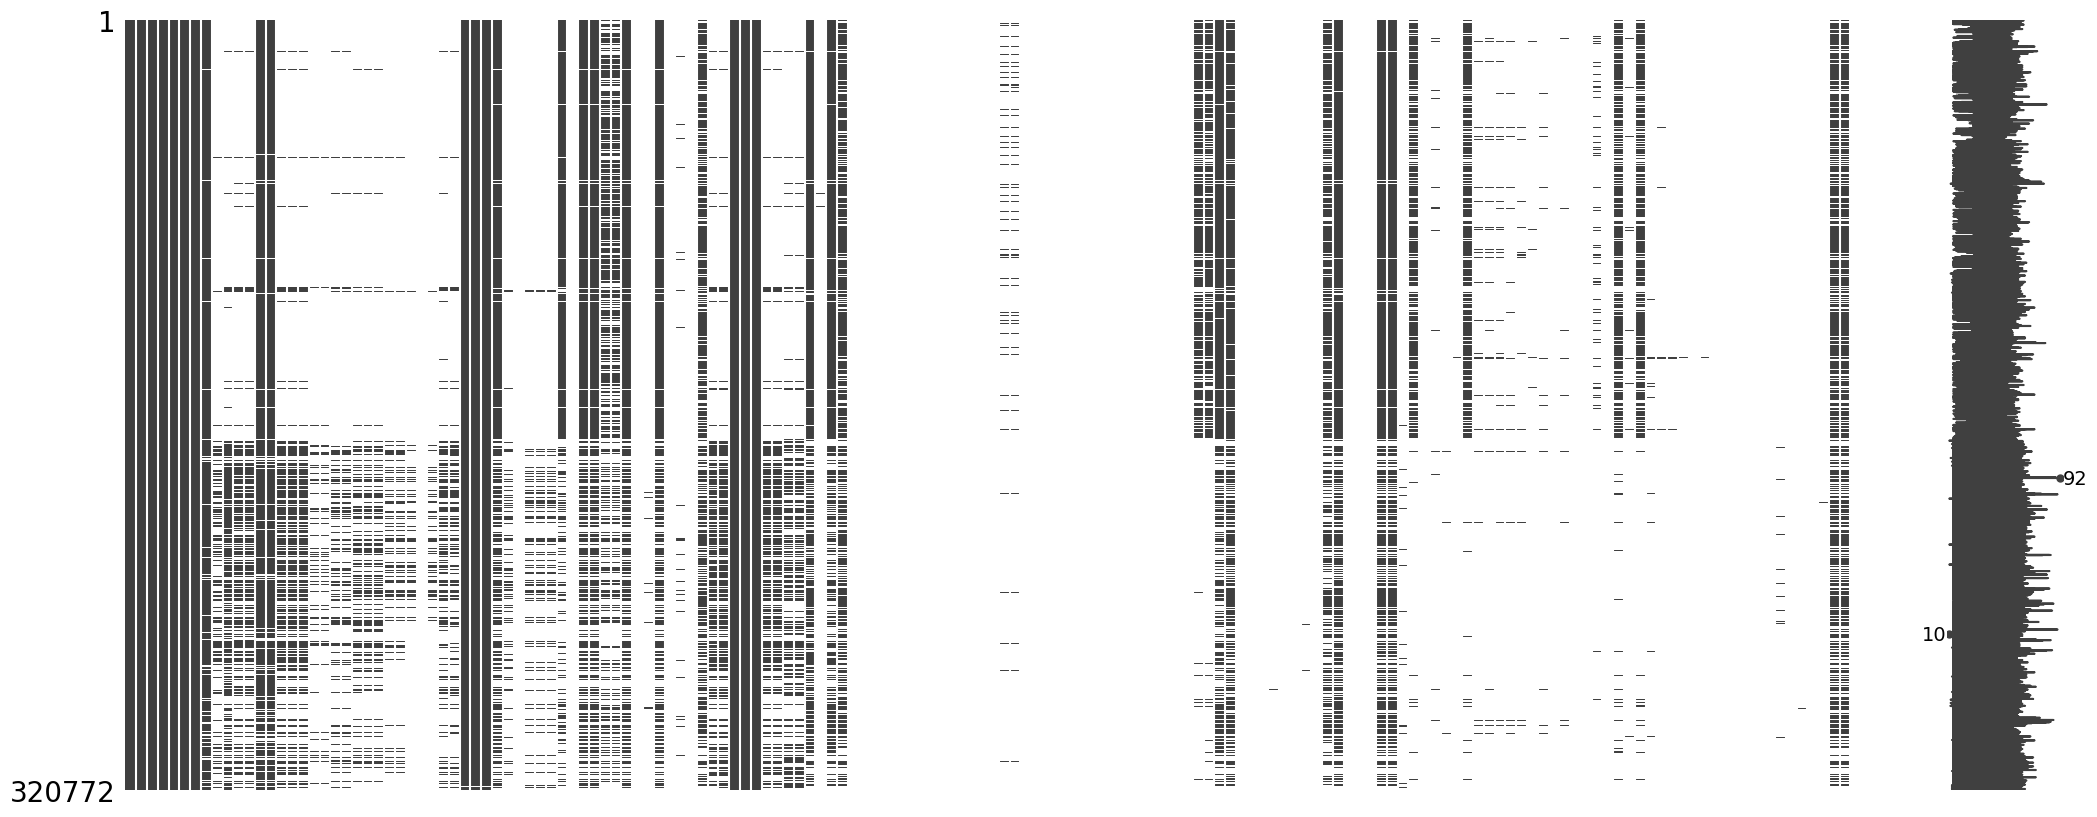

In [3]:
msno.matrix(data)

# Filtrage et nettoyage des données

En guise de fil directeur de notre étude, on se propose d'estimer les catégories de Nutriscore (a, b, c, d, e) d'un produit à partir d'autres indicateurs.

## Sélection d'indicateurs pertinents

**Indicateurs sélectionnés pour l'étude du nutriscore :**
- Code (code) : pour identifier le produit.
- Nom (product_name) : pour décrire le produit.
- Energie (energy_100g) : apport énergétique total en kcal pour 100g.
- Graisses (fat_100g) : quantité totale de graisses pour 100g.
- Graisses saturées (saturated-fat_100g) : quantité de graisses saturées pour 100g.
- Sucres (sugars_100g) : quantité totale de sucres pour 100g.
- Sodium (sodium_100g) : quantité de sel pour 100g.
- Fibres (fiber_100g) : quantité de fibres alimentaires pour 100g.
- Protéines (proteins_100g) : quantité de protéines pour 100g.
- Fruits et légumes (fruits-vegetables-nuts_100g) : quantité de fruits, légumes et noix pour 100g.
- Huile de palme (ingredients_from_palm_oil_n) : présence ou non d'huile de palme.
- Score nutritif (nutrition-score-fr_100g) : note numérique.
- Nutriscore (nutrition_grade_fr) : note de A à E.

Concernant l'huile de palme, l'indicateur **ingredients_from_palm_oil** étant vide à 100%, on se base sur l'indicateur **ingredients_from_palm_oil_n** qui indique le nombre d'ingrédients contenant de l'huile de palme.

In [4]:
def selectionner_indicateurs(source) :

    new_names = {"code" : "Code",
                 "product_name" : "Nom",
                 "energy_100g" : "Energie",
                 "fat_100g" : "Graisses",
                 "saturated-fat_100g" : "Graisses saturées",
                 "sugars_100g" : "Sucres",
                 "sodium_100g" : "Sodium",
                 "fiber_100g" : "Fibres",
                 "proteins_100g" : "Protéines",
                 "fruits-vegetables-nuts_100g" : "Fruits et légumes",
                 "ingredients_from_palm_oil_n" : "Huile de palme",
                 "nutrition-score-fr_100g" : "Score nutritif",
                 "nutrition_grade_fr" : "Nutriscore"}

    df = source[list(new_names)]
    df = df.rename(columns = new_names)

    # On change "Huile de palme" pour indiquer simplement la présence ou non d'huile de palme dans le produit.
    df["Huile de palme"] = df["Huile de palme"].apply(lambda x: "Oui" if x > 0 else ("Non" if x == 0 else x))
    
    return df


df = selectionner_indicateurs(data)
df.sample(5)

,Code,Nom,Energie,Graisses,Graisses saturées,Sucres,Sodium,Fibres,Protéines,Fruits et légumes,Huile de palme,Score nutritif,Nutriscore
293431,7613269224099,NaN,1004.0,12.0,4.0,3.5,0.629921,2.0,10.0,NaN,NaN,9.0,c
255817,3870007052855,Laganini Pudding,1590.0,2.5,0.0,0.0,1.010000,0.0,0.0,NaN,Non,14.0,d
261046,4021234202066,Krunchy al Cioccolato Bio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272677,50413386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199333,3210760828388,2 brioches façon pain perdu,1218.0,14.0,9.0,12.9,0.236220,1.5,6.6,NaN,NaN,13.0,d


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Code               320749 non-null  object 
 1   Nom                303010 non-null  object 
 2   Energie            261113 non-null  float64
 3   Graisses           243891 non-null  float64
 4   Graisses saturées  229554 non-null  float64
 5   Sucres             244971 non-null  float64
 6   Sodium             255463 non-null  float64
 7   Fibres             200886 non-null  float64
 8   Protéines          259922 non-null  float64
 9   Fruits et légumes  3036 non-null    float64
 10  Huile de palme     248939 non-null  object 
 11  Score nutritif     221210 non-null  float64
 12  Nutriscore         221210 non-null  object 
dtypes: float64(9), object(4)
memory usage: 31.8+ MB


## Valeurs aberrantes

**Nettoyage préliminaire :**

- On supprime éventuelles lignes en double.
- On supprime les lignes n'ayant que des valeurs manquantes.
- On supprime les produits dont l'un des nutriments n'est pas compris entre 0 et 100.
- On supprime les produits dont la somme des nutriments excède 100.
- On supprime les produits ayant plus de graisses saturées que de graisses totales.
- On supprime les produits ayant plus un apport énergétique supérieur à 1000 kcal.

Afin d'automatiser ces suppressions sur de futures données, on les englobe dans une fonction **supprimer_lignes_aberrantes**.

In [6]:
def supprimer_lignes_aberrantes(df, seuil_energie = 1000000) :
    
    # Filtre 1 : graisses saturées strictement supérieures aux graisses
    condition_1 = (df["Graisses saturées"] > df["Graisses"])

    # Filtre 2 : énergie anormalement élevée
    condition_2 = (df["Energie"] > seuil_energie)

    # Filtre 3 : somme des nutriments supérieure à 100g
    features = ["Graisses", "Sucres", "Sodium", "Fibres", "Protéines", "Fruits et légumes"]
    condition_3 = (df[features].sum(axis = 1) > 100)

    # Filtre 4 : nutriment supérieur à 100g
    features.append("Graisses saturées")
    condition_4 = (df[features] > 100).any(axis = 1)

    # Filtre 5 : valeurs négatives
    features.append("Energie")
    condition_5 = (df[features] < 0).any(axis = 1)

    # Application des filtres :
    produits_aberrants = df[condition_1 | condition_2 | condition_3 | condition_4 | condition_5]
    df = df.drop(produits_aberrants.index)

    # Suppression des lignes en double :
    df = df.drop_duplicates(subset = ["Code"])

    # Suppression des lignes n'ayant que des valeurs manquantes pour les indicateurs numériques :
    features.append("Score nutritif")
    df = df.dropna(subset = features, how = "all")

    return df

In [7]:
df = supprimer_lignes_aberrantes(df)

## Valeurs manquantes

<Axes: >

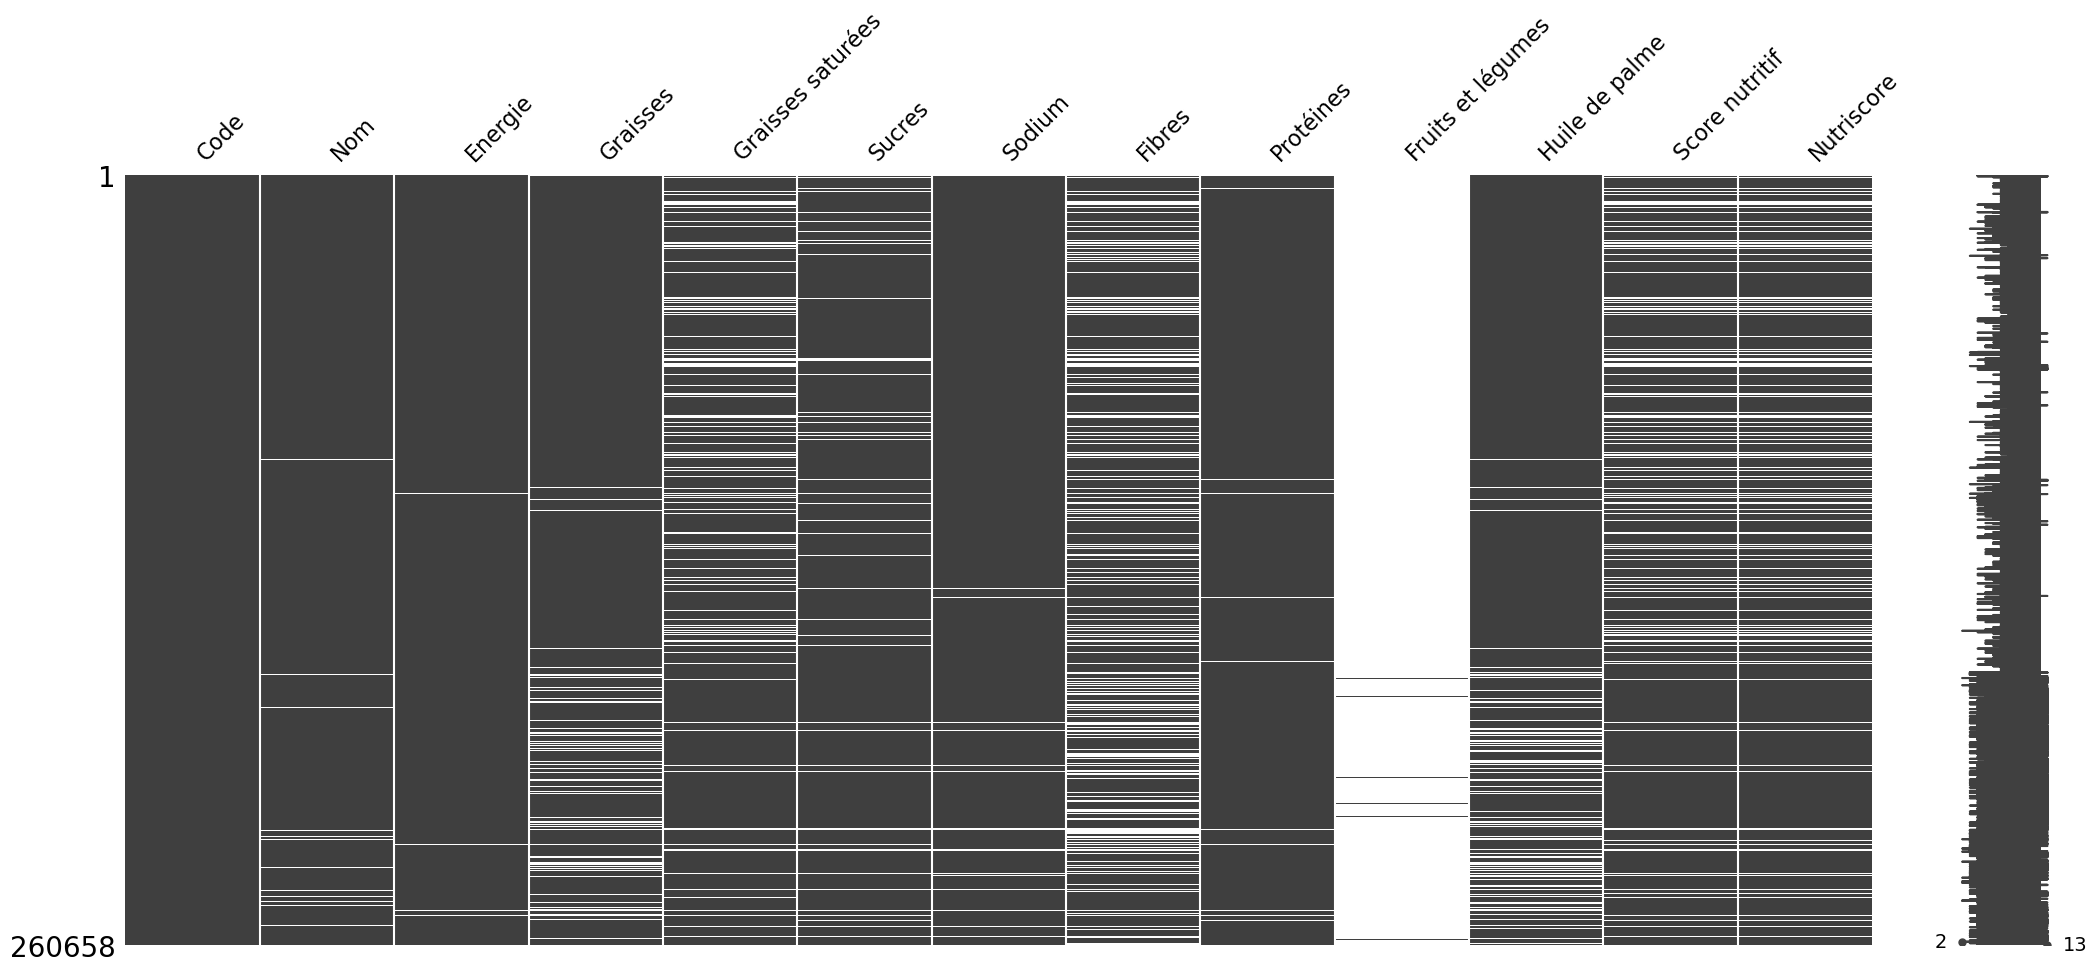

In [8]:
msno.matrix(df)

In [9]:
missing_percentage = (df.isna().mean() * 100).round(2)
missing_percentage_series = pd.Series(missing_percentage, name = "Pourcentage de valeurs manquantes")
    
for column_name, percentage in missing_percentage_series.items():
    print(f"{percentage}%\t{column_name}")

0.0%	Code
1.28%	Nom
0.65%	Energie
7.23%	Graisses
12.71%	Graisses saturées
6.83%	Sucres
2.8%	Sodium
23.59%	Fibres
1.1%	Protéines
99.08%	Fruits et légumes
10.39%	Huile de palme
15.88%	Score nutritif
15.88%	Nutriscore


**Stratégies pour gérer les valeurs manquantes :**

- Suppression de la ligne : utilisé précédemment quand les valeurs des indicateurs numériques étaient toutes manquantes.
- Remplissage : par zéro, par la moyenne ou par la médiane.
- Imputation k-Nearest Neighbours : estimation algorithmique basée sur les lignes ayant des valeurs voisines.

In [10]:
def remplir_valeurs_manquantes(df, features, strategy) :
    
    if strategy == "Zéro" :
        df[features] = df[features].fillna(0)
        
    elif strategy == "Moyenne" :
        for feature in features :
            mean = df[feature].mean()
            df[feature] = df[feature].fillna(mean)
            
    elif strategy == "Médiane" :
        for feature in features :
            median = df[feature].median()
            df[feature] = df[feature].fillna(median)

In [11]:
def knn_imputer(df, features, k = 5) :
    
    imputer = KNNImputer(n_neighbors = k)
    df[features] = imputer.fit_transform(df[features])

# Analyse univariée

## Boxplots des variables numériques

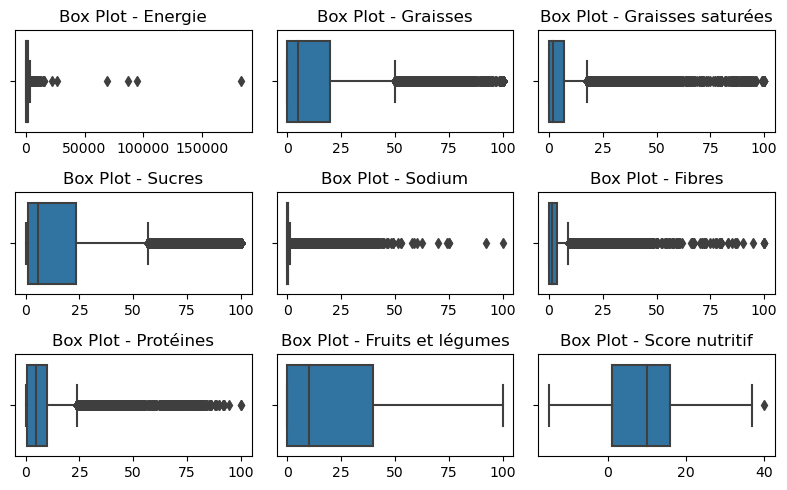

In [12]:
def plot_boxplots(df, features, showfliers = True) :

    plt.figure(figsize = (8, 5))
    
    for i, feature in enumerate(features):
        plt.subplot(3, 3, i + 1)
        sns.boxplot(x = df[feature], showfliers = showfliers)
        plt.title(f"Box Plot - {feature}")
        plt.gca().invert_yaxis()
        plt.xlabel("")
    
    plt.tight_layout()
    plt.show()

numerical_features = df.select_dtypes(include = ["int64", "float64"]).columns
plot_boxplots(df, numerical_features)

**Remarque :** <br>
Hormis pour l'énergie où quelques valeurs paraissent particulièrement extrêmes, il ne semble pas y avoir d'anomalie.

In [13]:
df.loc[df["Energie"] > 20000]

,Code,Nom,Energie,Graisses,Graisses saturées,Sucres,Sodium,Fibres,Protéines,Fruits et légumes,Huile de palme,Score nutritif,Nutriscore
119184,619309100979,"Sophia, Italian Drink, Squeezed Lime",94140.0,0.0,0.00,0.0,NaN,0.0,0.06,NaN,Non,NaN,NaN
153704,821372100200,Salsa Hot Sauce,26861.0,0.4,NaN,NaN,0.456000,NaN,2.80,NaN,Non,NaN,NaN
176697,2000000045489,bubbly,22000.0,29.5,18.00,54.0,0.110000,1.8,8.90,NaN,NaN,29.0,e
219302,3270160689774,NaN,69292.0,0.5,0.01,11.5,0.003937,3.4,0.80,NaN,NaN,8.0,c
249101,3661405001053,"Légume Noisettes Carottes, 500 Grammes, Marque...",182764.0,9.0,2.00,4.5,0.468504,3.5,4.00,NaN,NaN,12.0,d
317171,8854404001734,NaN,87217.0,0.0,NaN,8.8,0.000000,NaN,3.80,NaN,NaN,NaN,NaN


**Remarque :**<br>
La valeur la plus élevée paraît étrange, peut-être s'agit-il d'une erreur d'unité à la saisie.

In [14]:
if 249101 in df.index:
    df = df.drop(249101)

Réaffichons à présent les boxplots sans le premier et le dernier déciles.

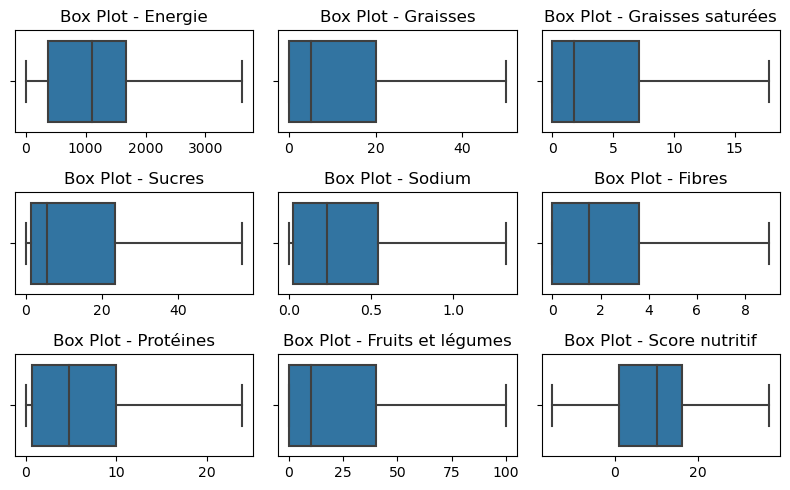

In [15]:
plot_boxplots(df, numerical_features, showfliers = False)

## Distribution des variables numériques

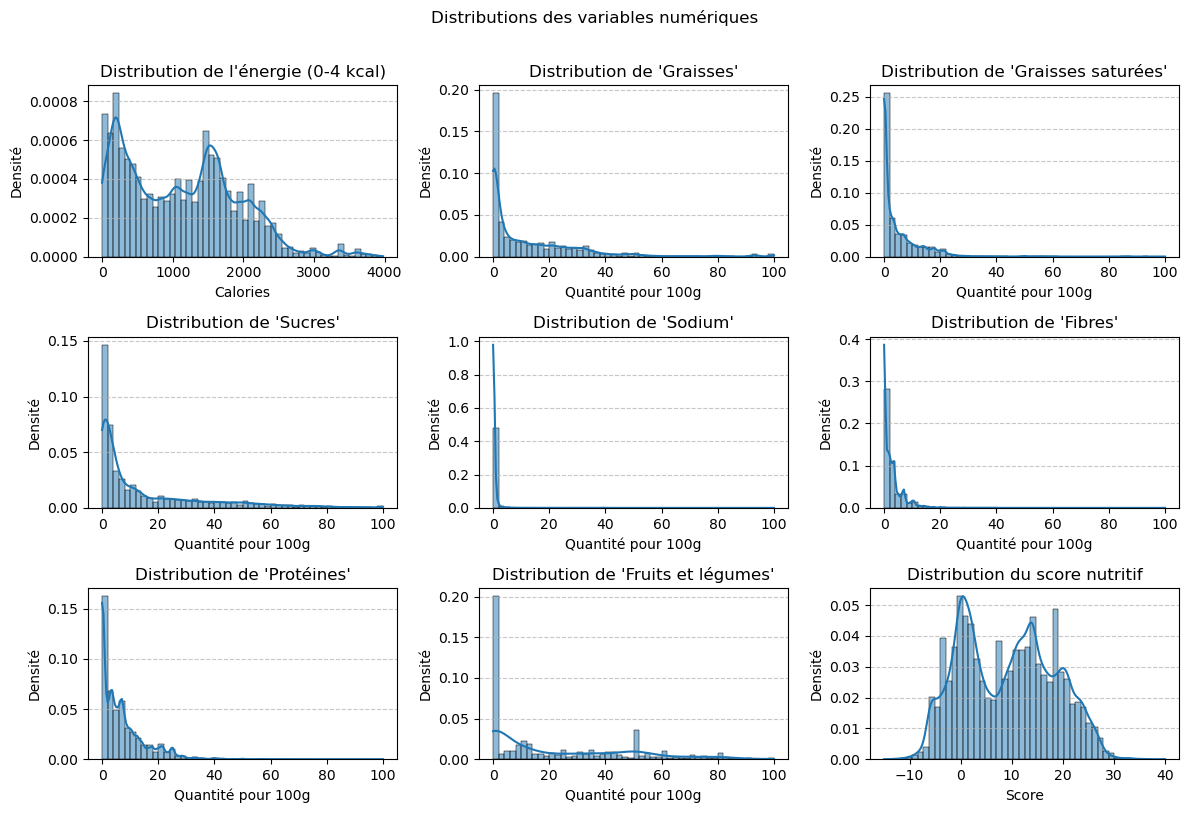

In [16]:
def plot_distribution(ax, df, feature, title, legend, bins = 50):
    sns.histplot(df[feature], bins = bins, kde = True, stat = "density", ax = ax)
    ax.set_title(title)
    ax.set_xlabel(legend)
    ax.set_ylabel("Densité")
    ax.grid(axis = "y", linestyle = "--", alpha = 0.7)

fig, axes = plt.subplots(3, 3, figsize = (12, 8))
plt.suptitle("Distributions des variables numériques", y = 1.01)

plot_distribution(axes[0, 0], df[df["Energie"] < 4000], "Energie", "Distribution de l'énergie (0-4 kcal)", "Calories")

features = ["Graisses", "Graisses saturées", "Sucres", "Sodium", "Fibres", "Protéines", "Fruits et légumes"]

for i, feature in enumerate(features) :
    row, col = divmod(i + 1, 3)  # Calcul de la position (ligne, colonne)
    plot_distribution(axes[row, col], df, feature, f"Distribution de '{feature}'", "Quantité pour 100g")

plot_distribution(axes[2, 2], df, "Score nutritif", "Distribution du score nutritif", "Score")
    
plt.tight_layout()
plt.show()

Pour l'énergie, on se restreint aux valeurs inférieures à 4000 calories afin d'avoir un histogramme plus lisible.

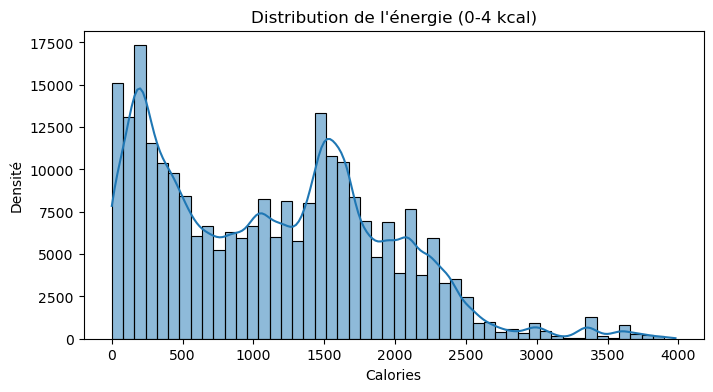

In [17]:
plt.figure(figsize = (8, 4)) 

sns.histplot(data = df[df["Energie"] < 4000], x = "Energie", bins = 50, kde = True)

plt.xlabel("Calories")
plt.ylabel("Densité")
plt.title("Distribution de l'énergie (0-4 kcal)")

plt.show()

**Remarques :**
    
- Les nutriments ont tous des distributions unimodales avec un mode à zéro : on pourra remplir les valeurs manquantes par des zéros, d'autant qu'une absence de nutriment dans le produit peut vraisemblablement expliquer une absence de valeur saisie.
- L'énergie et le score nutritif ont des distributions bimodales : il faudra étudier leur corrélation avec les autres variables.

## Distribution des variables catégorielles

In [18]:
counts = df["Huile de palme"].value_counts()
counts = pd.DataFrame(counts)
counts = counts.rename(columns = {"count": "Effectif"})
counts["Pourcentage"] = (counts["Effectif"] / counts["Effectif"].sum() * 100).round(1).astype(str) + " %"
counts

,Effectif,Pourcentage
Huile de palme,,
Non,229040,98.1 %
Oui,4536,1.9 %


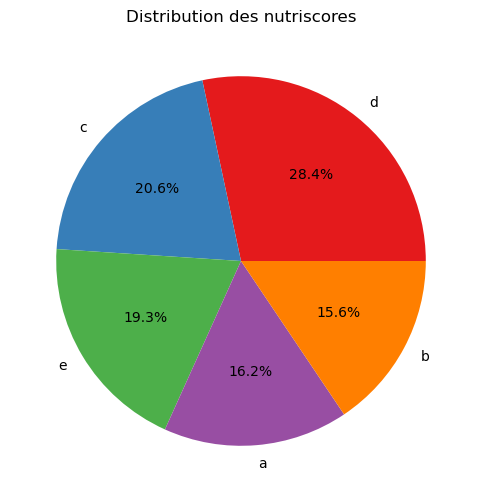

In [19]:
counts = df["Nutriscore"].value_counts()

plt.figure(figsize = (10, 6))
plt.pie(counts, labels = counts.index, colors = sns.color_palette("Set1"), autopct = "%1.1f%%")
plt.title(f"Distribution des nutriscores")
plt.show()

**Remarques** :

- Pour l'huile de palme, il sera judicieux de remplacer les valeurs manquantes de par "Non".l
- Pour le nutriscore, la distribution est à peu près uniforme.

# Analyse bivariée

## Corrélations entre variables numériques

### Pairplots

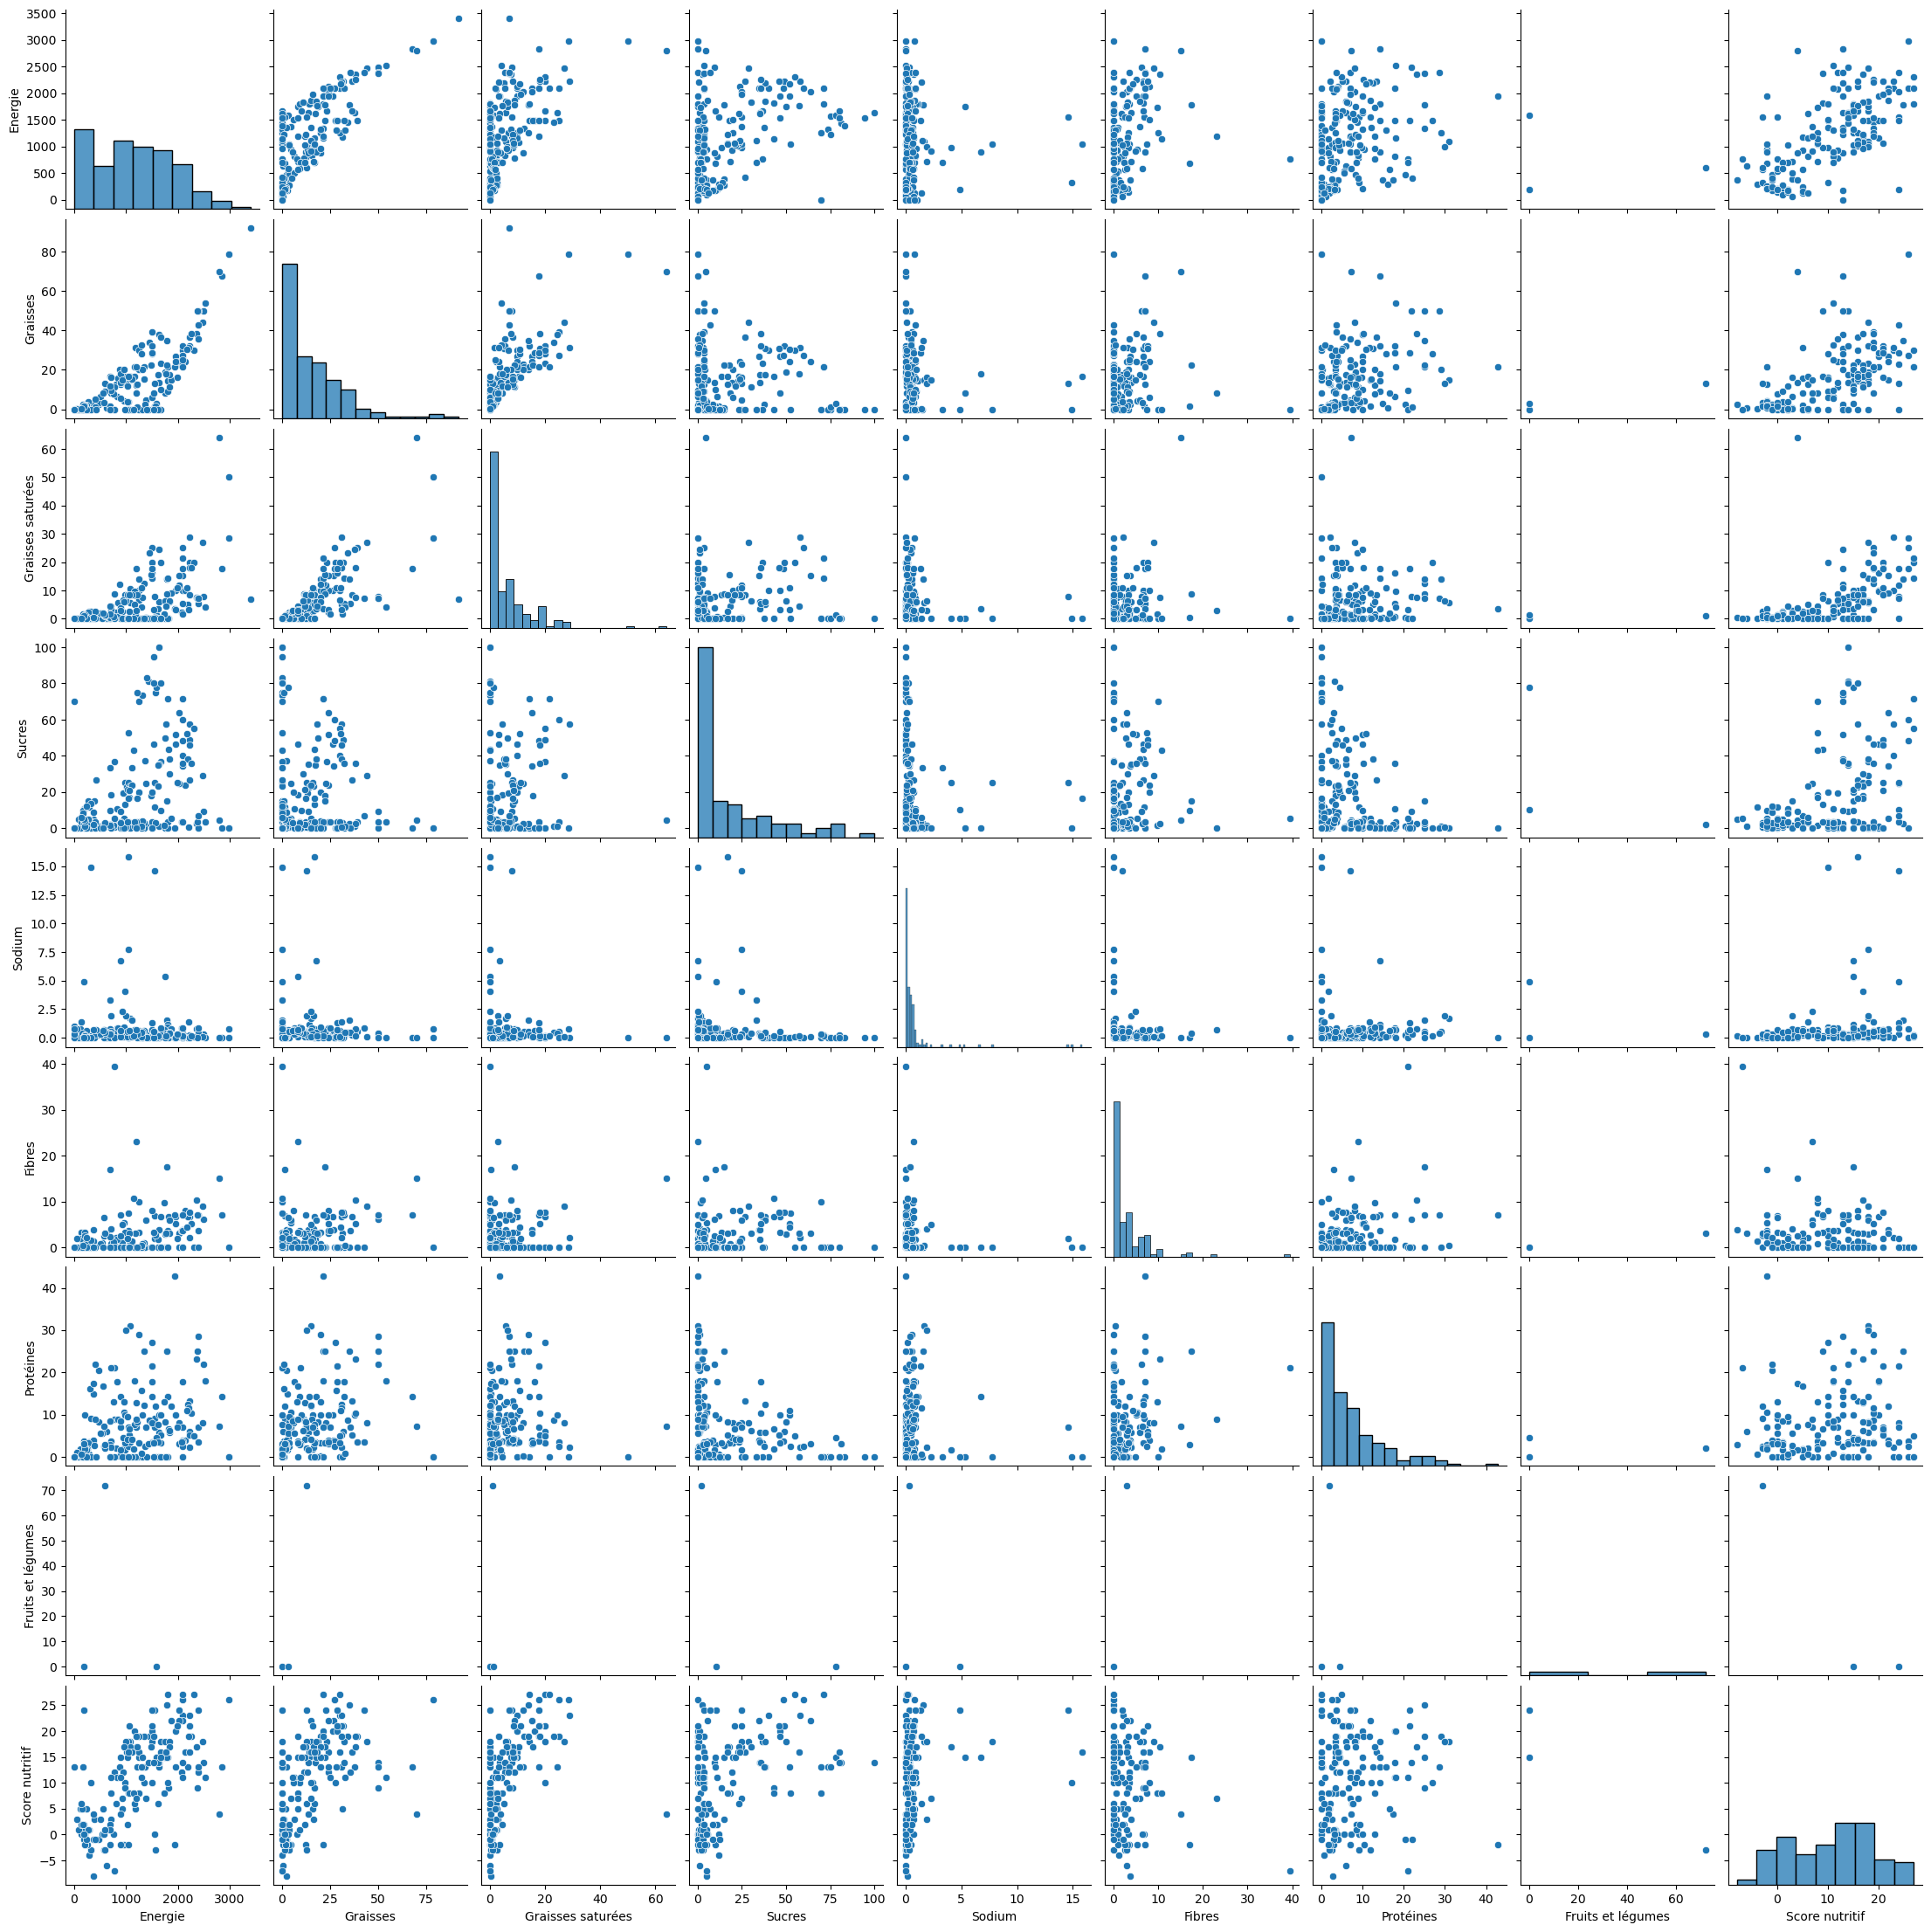

In [20]:
sns.pairplot(df[numerical_features].sample(200))

**Remarque :**<br>
Certaines variables semblent avoir des dépendances linéaires, comme par exemple entre l'énergie et les graisses.

### Matrice de corrélation

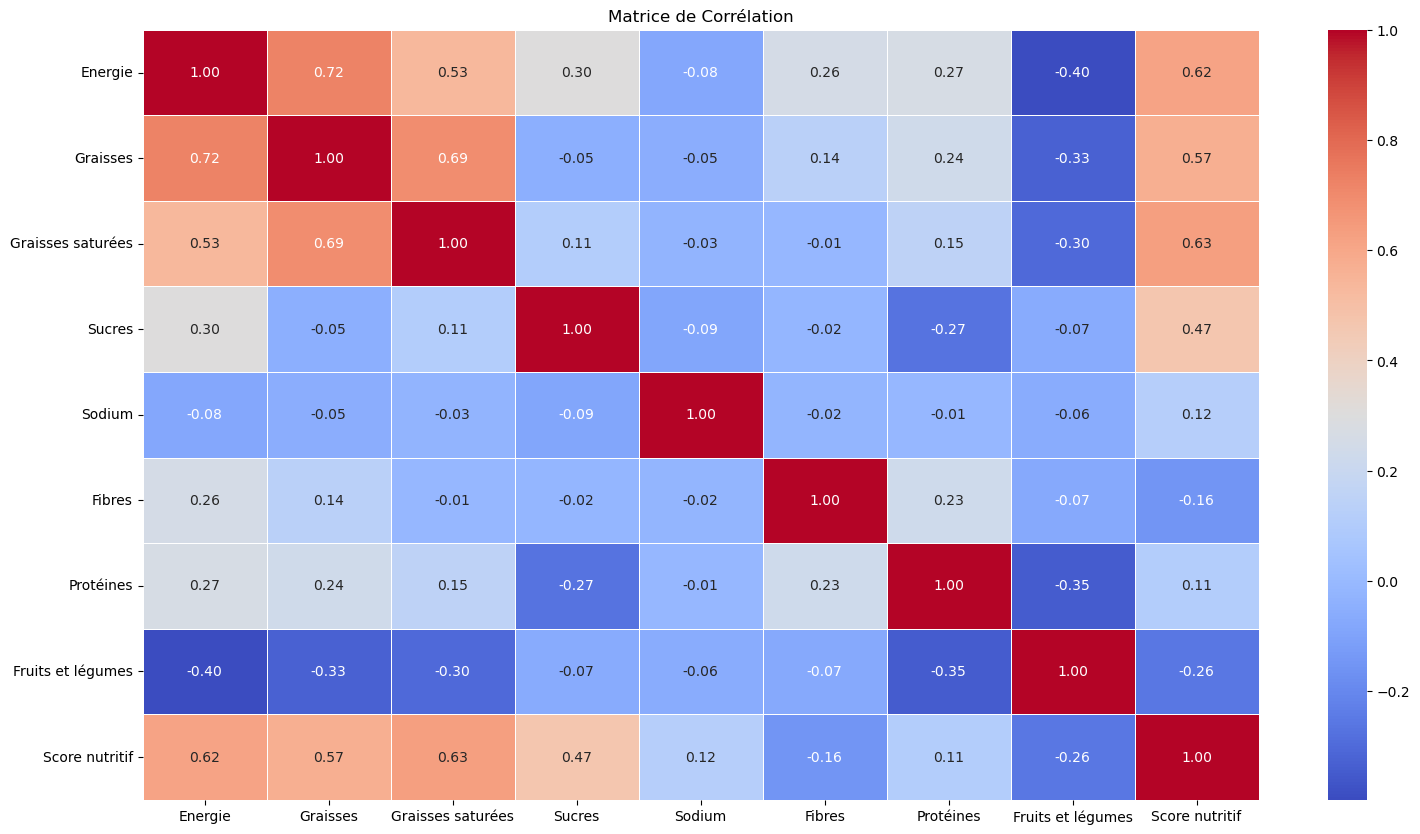

In [21]:
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize = (18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap = "coolwarm", fmt = ".2f", linewidths = 0.5)
plt.title("Matrice de Corrélation")
plt.show()

**Remarques :**
    
- On constate une forte corrélation entre l'énergie, les graisses et les graisses saturées.
- Le score nutritif est lui aussi fortement corrélé à ces trois grandeurs ainsi qu'aux sucres.

## Variables numériques en fonction du nutriscore

### Boxplots

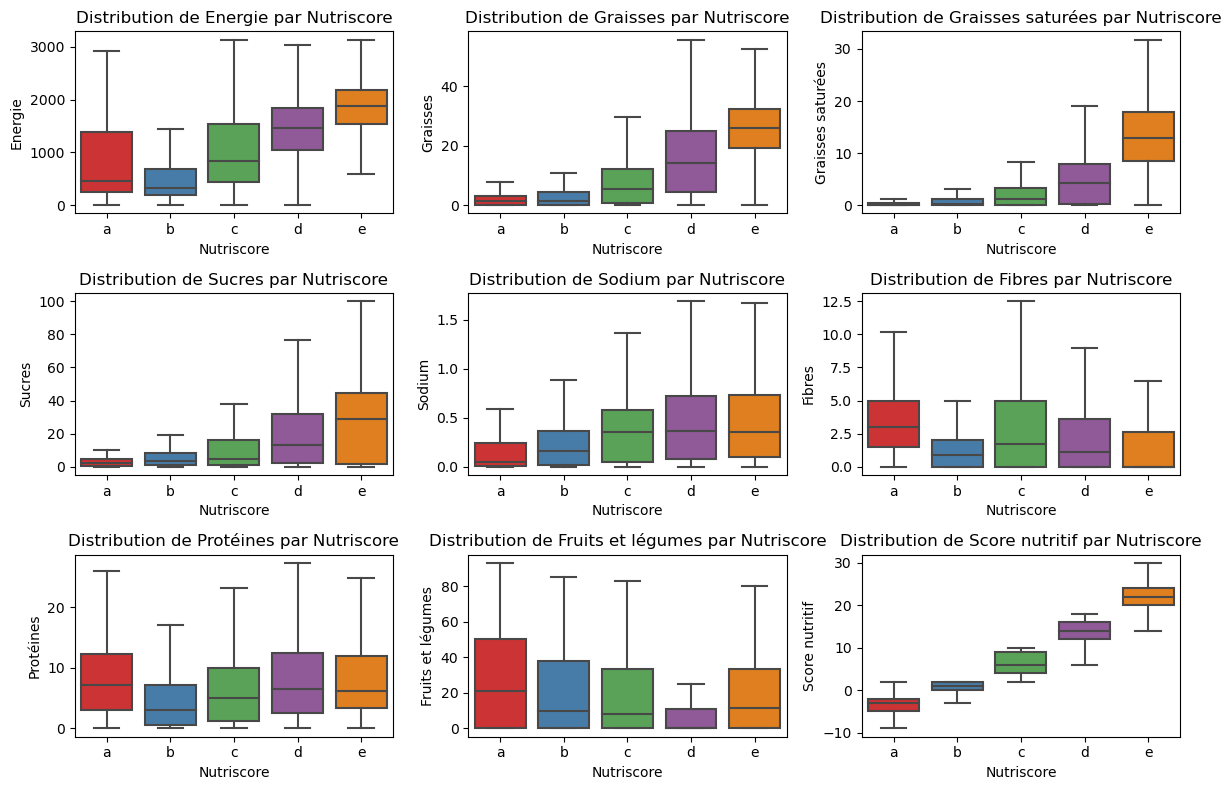

In [22]:
order = ["a", "b", "c", "d", "e"]
palette = sns.color_palette("Set1")

fig, axes = plt.subplots(3, 3, figsize = (12, 8))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    ax = axes[i]
    sns.boxplot(data = df, x = "Nutriscore", y = feature, showfliers = False, order = order, palette = palette, ax = ax)
    ax.set_title(f"Distribution de {feature} par Nutriscore")
    ax.set_xlabel("Nutriscore")
    ax.set_ylabel(feature)

plt.tight_layout()
plt.show()

**Remarques :**
    
- On retrouve que les catégories du nutriscore sont fortement corrélées à certains nutriments : énergie, graisses, graisses saturées et sucres.
- Le score nutritif n'est pas l'unique facteur qui détermine les catégories du nutriscore puisque les boxplots se chevauchent.

### Anova

In [23]:
def eta_squared(df, categorical_feature, numerical_feature) :
       
    x = df[categorical_feature]
    y = df[numerical_feature]
    
    moyenne_y = y.mean()
    
    classes = []
    for classe in x.unique():
        yi_classe = y[x == classe]
        classes.append({"ni" : len(yi_classe), "moyenne_classe" : yi_classe.mean()})
    
    SCT = sum([(yj - moyenne_y) ** 2 for yj in y])
    SCE = sum([c["ni"] * (c["moyenne_classe"] - moyenne_y) ** 2 for c in classes])
    
    return SCE / SCT

In [24]:
results = []

for feature in numerical_features :
    echantillon = df[[feature, "Nutriscore"]].dropna()
    result = eta_squared(echantillon, "Nutriscore", feature)
    results.append({"Variable" : feature, "Eta carré" : result})

eta_squared_df = pd.DataFrame(results)
eta_squared_df  = eta_squared_df.sort_values(by = "Eta carré", ascending = False)
print("Calcul du eta carré pour le nutriscore par rapport à chaque variable numérique :\n")
print(eta_squared_df.to_string(index = False))

Calcul du eta carré pour le nutriscore par rapport à chaque variable numérique :

         Variable  Eta carré
   Score nutritif   0.930718
Graisses saturées   0.416077
          Energie   0.358810
         Graisses   0.301716
           Sucres   0.196469
           Fibres   0.058459
Fruits et légumes   0.054472
        Protéines   0.029469
           Sodium   0.019044


In [25]:
for feature in numerical_features :
    echantillon = df[[feature, "Nutriscore"]].dropna()

    groups = [echantillon[echantillon["Nutriscore"] == value][feature] for value in echantillon["Nutriscore"].unique()]
    f_statistic, p_value = f_oneway(*groups)

    print(f"ANOVA pour {feature} vs Nutriscore :")
    print(f"   p-value : {p_value : .10f}")

ANOVA pour Energie vs Nutriscore :
   p-value :  0.0000000000
ANOVA pour Graisses vs Nutriscore :
   p-value :  0.0000000000
ANOVA pour Graisses saturées vs Nutriscore :
   p-value :  0.0000000000
ANOVA pour Sucres vs Nutriscore :
   p-value :  0.0000000000
ANOVA pour Sodium vs Nutriscore :
   p-value :  0.0000000000
ANOVA pour Fibres vs Nutriscore :
   p-value :  0.0000000000
ANOVA pour Protéines vs Nutriscore :
   p-value :  0.0000000000
ANOVA pour Fruits et légumes vs Nutriscore :
   p-value :  0.0000000000
ANOVA pour Score nutritif vs Nutriscore :
   p-value :  0.0000000000


**Remarque :**<br>
On retrouve que les catégories du nutriscore sont corrélées aux variables étudiées, en particulier l'énergie, les graisses, les graisses saturées et les sucres.

## Huile de palme et nutriscore

### Contributions à la non-indépendance

In [26]:
X = "Huile de palme"
Y = "Nutriscore"

echantillon = df[[X, Y]].dropna()

cont = echantillon[[X, Y]].pivot_table(index = X, columns = Y, aggfunc = len, margins = True, margins_name = "Total")

print("Matrice de contingence :")
cont

Matrice de contingence :


Nutriscore,a,b,c,d,e,Total
Huile de palme,,,,,,
Non,31903,29932,39257,53706,35363,190161
Oui,65,169,670,1481,1846,4231
Total,31968,30101,39927,55187,37209,194392


In [27]:
totaux_lignes = cont.loc[:, ["Total"]]
totaux_colonnes = cont.loc[["Total"], :]
total_general = len(echantillon)

indep = totaux_lignes.dot(totaux_colonnes) / total_general

print("Matrice des effectifs attendus :")
indep

Matrice des effectifs attendus :


Nutriscore,a,b,c,d,e,Total
Huile de palme,,,,,,
Non,31272.206922,29445.842735,39057.976907,53985.838445,36399.13499,190161.0
Oui,695.793078,655.157265,869.023093,1201.161555,809.86501,4231.0
Total,31968.000000,30101.000000,39927.000000,55187.000000,37209.00000,194392.0


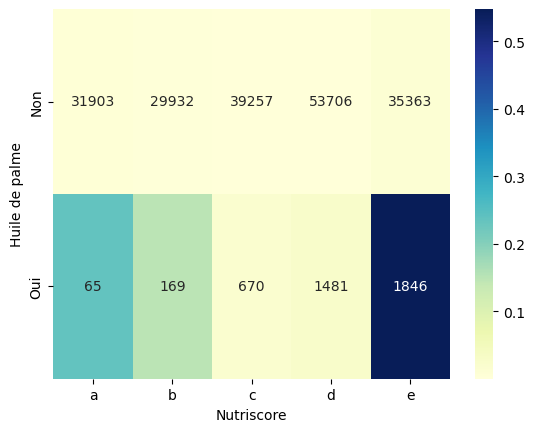

In [28]:
mesure = (cont - indep) ** 2 / indep
xi_n = mesure.sum().sum()
table = mesure / xi_n

sns.heatmap(table.iloc[:-1, :-1], annot = cont.iloc[:-1, :-1], cmap = "YlGnBu", fmt = "d", cbar = True)
plt.show()

### Test du chi-deux

In [29]:
chi2_global, p_global, _, _ = chi2_contingency(cont.iloc[:-1, :-1])

print("Test du chi-deux global :")
print(f"chi_deux = {chi2_global:.4f}")
print(f"p-value = {p_global:.8f}")

Test du chi-deux global :
chi_deux = 2421.7243
p-value = 0.00000000


In [30]:
p_values = []

for i in range(cont.shape[0] - 1) :
    for j in range(cont.shape[1] - 1) :
        cell = cont.iloc[i, j]
        chi2, p, _, _ = chi2_contingency([[cell, cont.iloc[i, -1]], [cont.iloc[-1, j], cont.iloc[-1, -1]]])
        p_values.append(p)

p_values_df = pd.DataFrame(np.array(p_values).reshape(cont.shape[0] - 1, cont.shape[1] - 1), index=cont.index[:-1], columns=cont.columns[:-1])      

formatted_p_values_df = p_values_df.applymap(lambda x: f"{x:.8f}")

print("Table des p-values pour le chi_deux (tests locaux) :")
formatted_p_values_df

Table des p-values pour le chi_deux (tests locaux) :


Nutriscore,a,b,c,d,e
Huile de palme,,,,,
Non,0.01966753,0.06269197,0.51745019,0.45116047,0.00036694
Oui,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


**Remarque :**<br>
Ce test révèle que la présence d'huile de palme est corrélée aux catégories du Nutriscore.

# Analyse en Composantes Principales

## Détermination des composantes

In [31]:
echantillon = df[numerical_features].dropna()
echantillon_standardise = (echantillon - echantillon.mean()) / echantillon.std()

pca = PCA()
pca.fit(echantillon_standardise)
components = pca.components_
eigenvalues = pca.explained_variance_ratio_

In [32]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = numerical_features
pcs.index = [f"PC{i + 1}" for i in range(pcs.shape[0])]

pcs_avec_var = pcs.copy()
pcs_avec_var["Variance expliquée"] = eigenvalues
pcs_avec_var.round(4)

,Energie,Graisses,Graisses saturées,Sucres,Sodium,Fibres,Protéines,Fruits et légumes,Score nutritif,Variance expliquée
PC1,0.4931,0.4690,0.4449,0.2182,0.0595,0.0820,0.2096,-0.2931,0.3889,0.3656
PC2,0.0506,0.0978,-0.0415,-0.5439,0.1448,0.3888,0.5348,-0.2513,-0.4111,0.1665
PC3,-0.1706,0.0058,0.0837,-0.2646,0.7214,-0.5744,0.0275,-0.1389,0.1534,0.1177
PC4,0.0811,-0.2412,-0.2947,0.4199,0.6139,0.5320,-0.0223,0.0158,0.1075,0.1037
PC5,-0.0004,0.3639,0.3215,-0.2986,0.2303,0.2911,-0.3705,0.6295,-0.0613,0.0956
PC6,0.0914,-0.0584,-0.0375,0.1844,0.0079,-0.2175,0.6919,0.6509,0.0563,0.0679
PC7,-0.5289,-0.2857,0.3199,-0.1931,-0.1218,0.3096,0.1854,-0.0218,0.5945,0.0414
PC8,-0.1949,-0.2544,0.6776,0.3785,0.1005,-0.0145,0.0465,-0.0736,-0.5263,0.0304
PC9,0.6265,-0.6558,0.2007,-0.3265,-0.0141,-0.0324,-0.1279,0.0753,0.0848,0.0112


## Eboulis des valeurs propres

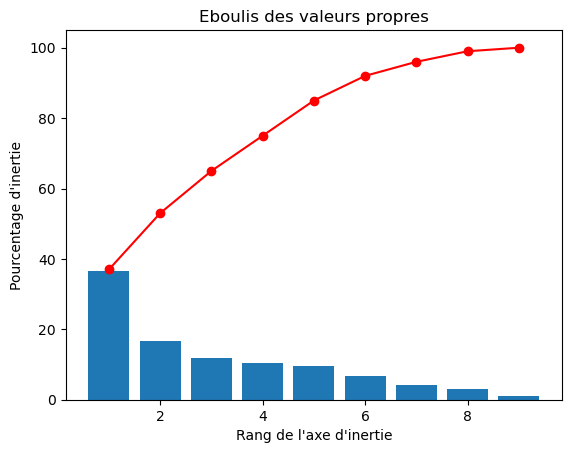

In [33]:
scree = (pca.explained_variance_ratio_ * 100).round(2)
scree_cum = scree.cumsum().round()
x_list = list(range(1, len(components) + 1))

plt.bar(x_list, scree)
plt.plot(x_list, scree_cum, c = "red", marker = "o")
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block = False)

## Heatmap des composantes

<Axes: >

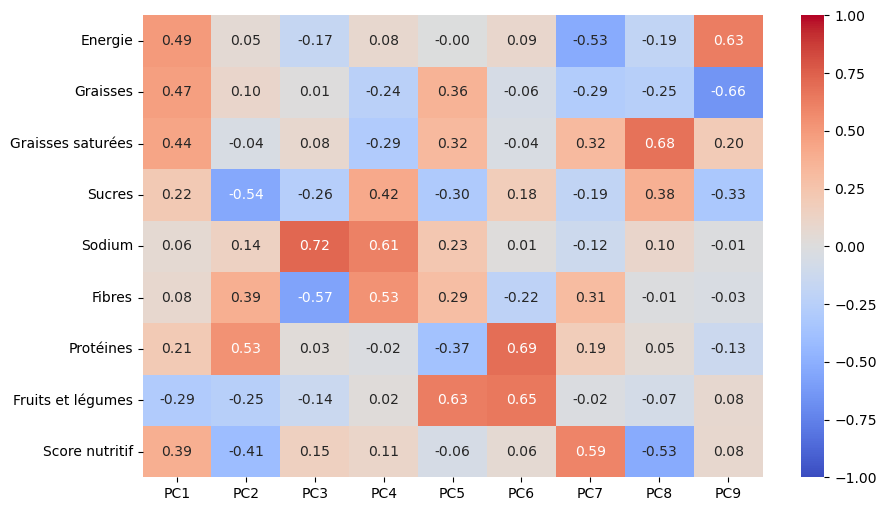

In [34]:
fig, ax = plt.subplots(figsize = (10, 6))
sns.heatmap(pcs.T, vmin = -1, vmax = 1, annot = True, cmap = "coolwarm", fmt = "0.2f")

# Conclusion

Au vu de l'analyse effectuée, on peut faire des choix concernant la gestion des valeurs manquantes (après suppression des lignes aberrantes).

**Remplissage :**
- La valeur "Non renseigné" pour les noms manquants.
- La valeur "Non" pour l'huile de palme car elle est largement majoritaire.
- Un remplissage par des zéros pour les sucres, le sodium, les fibres, les protéines et les fruits et légumes au vu de leurs distributions.

**Imputation k-Nearest Neighbours :**
- L'énergie, les graisses et les graisses saturées car elles sont fortement corrélées.
- Le score nutritif car il est déterminé par un procédé calculatoire basé sur les nutriments et l'énergie (on pourrait à terme utiliser directement ce procédé).

On aboutit à la fonction ci-dessous permettant d'effectuer tout le prétraitement des données.

In [35]:
def pretraitement(source) :
    
    df = selectionner_indicateurs(source, seuil_energie = 150000)
    
    supprimer_lignes_aberrantes(df)
    
    df["Nom"].fillna("Non renseigné", inplace = True)
    df["Huile de palme"].fillna("Non", inplace = True)
    
    selection_1 = ["Sucres", "Sodium", "Fibres", "Protéines", "Fruits et légumes"]
    remplir_valeurs_manquantes(df, selection_1, "Zéro")
    
    selection_2 = ["Energie", "Graisses", "Graisses saturées"]
    knn_imputer(df, selection_2)
    
    selection_3 = selection_1 + selection_2 + ["Huile de palme", "Score nutritif", "Nutriscore"]
    knn_imputer(df, selection_3)
    
    return df

Cette étude a montré que les données sont exploitables.

Plusieurs indicateurs sont corrélés les uns aux autres, ce qui peut à terme permettre d'utiliser des systèmes prédictifs :
- Estimation du Nutriscore.
- Détection d’erreurs de saisie.
- Système de suggestion ou d’auto-complétion lors de la saisie.

Le projet de l'agence Santé Publique France paraît donc envisageable.

Il reste encore à utiliser des algorithmes d’apprentissage automatique pour exploiter ces données (une ACP pouvant aider à gagner en performance), puis à les intégrer à l’interface de saisie du site Open Food Facts.